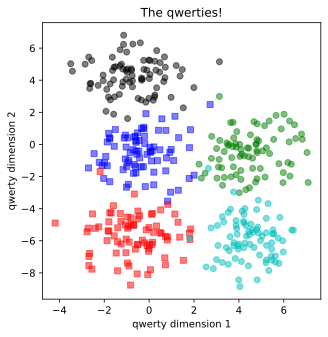

Pytorch version: 1.10.2


In [2]:
import numpy as np
import torch
from jagpascoe_ML_toolkit.createDataFunctions import createQwerties, splitData
data, labels = createQwerties(clusters=5, nPerClust=80, blur=1.20, centroids=np.array([[0,0],[0,5],[0,-5],[5,0],[5,-5]]), draw=True)

print(f"Pytorch version: {torch.__version__}")

In [2]:

train_loader, dev_loader, test_loader = splitData(partitions=[0.85,0.075], batch_size=30, data=data, labels=labels, verbose=True)

   Total data size: torch.Size([400, 2])

Training data size: torch.Size([340, 2])
Trainning Label data size: torch.Size([340])
Dev data size: torch.Size([29, 2])
Dev Label data size: torch.Size([29])
Dev test size: torch.Size([31, 2])
Dev test data size: torch.Size([31])


In [3]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import copy
import matplotlib.pyplot as plt

class mClass(nn.Module):
    '''
    this Class models a Multi classificator in Pytorch
    '''
  

    def __init__(self, nImputs, nOutputs, hidden, nHidden, activation=F.relu, dr=0.0):
      super().__init__()

      #Create a dictionary to save the layers
      self.layers = nn.ModuleDict()
      self.nImputs = nImputs
      self.nOutputs = nOutputs
      self.hidden = hidden
      self.nHidden = nHidden
      self.dr = dr #Dropuot rate
      self.activation=activation

      self.trainAcc = [] #for storing the accuracy vectors of trainning and dev
      self.devAcc = []
      self.losses = [] #for storing losses at trainning

      #This two vectors are for measure weight changes and withconds of the learnig process
      self.weightChanges = [] #This counts about how much is learning in each epoch
      self.weightConds = [] #this how much is specializing in anykind of particularlity
      
      ### input layer
      self.layers["input"] = nn.Linear(nImputs,nHidden)

      for h in range(self.hidden):      
      ### hidden layer
        self.layers[f'hidden{h}'] = nn.Linear(nHidden,nHidden)

      ### output layer
      self.layers['output'] = nn.Linear(nHidden,nOutputs)

    
    # forward pass
    def forward(self,x):
      x = self.activation( self.layers['input'](x) )
      x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
   
      for h in range(self.hidden):
        x = self.activation( self.layers[f'hidden{h}'](x) )
        x = F.dropout(x,p=self.dr,training=self.training) # switch dropout off during .eval()
        #x = F.softmax(x)
      return self.layers['output'](x)
   
   
   
    def testModel(self, n, test_loader):
      # extract X,y from test dataloader
      X,y = next(iter(test_loader)) 
      self.load_state_dict(n['net'])
      yHat = self.forward(X)
      bestAcc = 100*torch.mean((torch.argmax(yHat,axis=1)==y).float())
      return(bestAcc)


    def fit(self, train_loader, dev_loader, numepochs = 10, learningRate=0.01, lossFunction= nn.CrossEntropyLoss, 
            optimizer=torch.optim.Adam, weight_decay=0, initializer=None):
            
      # Initialize a dictionary for the best model
      theBestModel = {'Accuracy':0, 'net':None, 'epoch':0} #net will be the whole model instance

      self.weightChanges = np.zeros((numepochs, self.hidden+2)) #This two vectors are for measure weight changes and withconds of the learnig process
      self.weightConds = np.zeros((numepochs, self.hidden+2))

      if initializer == 'xavier':         #this set the methgod for iniatiazing weights
        for p in self.named_parameters():
          if 'weight' in p[0]:
            nn.init.xavier_normal_(p[1].data)
      elif initializer == 'kaiming': #it's kaiming
        for p in self.named_parameters():
          if 'weight' in p[0]:
            nn.init.kaiming_uniform_(p[1].data, nonlinearity='relu') #be sure that relu or leaky_relu is the activation

      # loss function
      self.lossfun = lossFunction()

      # optimizer
      self.optimizer = optimizer(params=self.parameters(), lr=learningRate, weight_decay=weight_decay)


      # initialize losses
      self.losses   = torch.zeros(numepochs)
      self.trainAcc = []
      self.devAcc   = []

      # loop over epochs
      for epochi in range(numepochs):

        # store the weights for each layer
        preW = []
        for p in self.named_parameters():
          if 'weight' in p[0]:
            preW.append( copy.deepcopy(p[1].data.numpy()) )
        
        
        # switch on training mode
        self.train()

        # loop over training data batches
        batchAcc  = []
        batchLoss = []
        for X,y in train_loader:

          # forward pass and loss
          yHat = self.forward(X)
          loss = self.lossfun(yHat,y)

          # backprop
          self.optimizer.zero_grad()
          loss.backward()
          self.optimizer.step()

          # loss from this batch
          batchLoss.append(loss.item())

          # compute accuracy
          matches = torch.argmax(yHat,axis=1) == y     # booleans (false/true)
          matchesNumeric = matches.float()             # convert to numbers (0/1)
          accuracyPct = 100*torch.mean(matchesNumeric) # average and x100 
          batchAcc.append( accuracyPct )               # add to list of accuracies
          # end of batch loop...

        # now that we've trained through the batches, get their average training accuracy
        self.trainAcc.append( np.mean(batchAcc) )

        # and get average losses across the batches
        self.losses[epochi] = np.mean(batchLoss)

        # test accuracy
        self.eval()
        X,y = next(iter(dev_loader)) # extract X,y from devset dataloader
        with torch.no_grad(): # deactivates autograd
          yHat = self.forward(X)
      
        # compare the following really long line of code to the training accuracy lines
        self.devAcc.append( 100*torch.mean((torch.argmax(yHat,axis=1)==y).float()) )


        # New! Store this model if it's the best so far
        if self.devAcc[-1]>theBestModel['Accuracy']:
      
          # new best accuracy
          theBestModel['Accuracy'] = self.devAcc[-1].item()
      
          # epoch iteration
          theBestModel['epoch'] = epochi

          # model's internal state
          theBestModel['net'] = copy.deepcopy( self.state_dict() ) #here update the best model
      
        # Get the post-learning state of the weights
        for (i,p) in enumerate(self.named_parameters()):
          if 'weight' in p[0]:
          # condition number, just for weights not bias
            self.weightConds[epochi,int(i/2)]  = np.linalg.cond(p[1].data)

            # Frobenius norm of the weight change from pre-learning
            self.weightChanges[epochi,int(i/2)] = np.linalg.norm( preW[int(i/2)]-p[1].data.numpy(), ord='fro')

  
        # end epochs

      # function output
      return self.trainAcc,self.devAcc,self.losses,theBestModel

    def drawModel(self, figsize=(15,18)):
      #plot results of trainning
      # set up the plot
      fig,ax = plt.subplots(3,2,figsize=figsize)
      ax = ax.flatten()

      # losses
      ax[0].plot(self.losses.detach(),'-')
      ax[0].set_ylabel('Loss')
      ax[0].set_xlabel('epoch')
      ax[0].set_title('Losses')
      #ax[0].set_ylim([0,0.6])

      #accuracy
      ax[1].plot(self.trainAcc,'-',label='Train')
      ax[1].plot(self.devAcc,'-',label='Devset')
      ax[1].set_ylabel('devAccuracy (%)')
      ax[1].set_xlabel('Epoch')
      ax[1].set_title('Accuracy')
      #ax[1].set_ylim([85,95])
      #ax[1].set_xlim([80,105])
      ax[1].legend()
      
      layername = []
      for (i,p) in enumerate(self.named_parameters()):
        if 'weight' in p[0]:
          layername.append(p[0][:-7])
      
      # weight changes
      # get a list of layer names
      
      ax[2].plot(self.weightChanges)
      ax[2].set_xlabel('Epochs')
      ax[2].set_title('Weight change from previous epoch')
      ax[2].legend(layername)
      #ax[2].set_ylim([0,0.2])
      #ax[2].set_yscale('log')

      # weight condition numbers
      ax[3].plot(self.weightConds)
      ax[3].set_xlabel('Epochs')
      ax[3].set_title('Condition number')
      ax[3].legend(layername)
      #ax[3].set_ylim([0,1000])
      #ax[3].set_yscale('log')

     #Graph an histogram of weights
     # store the weights for each layer
      preW = []
      for p in self.named_parameters():
        if 'weight' in p[0]:
           preW = np.append(preW, p[1].data.numpy())

      y,x = np.histogram(preW,30)
      ax[4].set_title('Total weight distribution after trainning')
      ax[4].plot((x[1:]+x[:-1])/2,y,'b')
      ax[4].set_xlabel('Weight value')
      ax[4].set_ylabel('Count')

    
      from scipy.stats import zscore # normalize for scaling offsets
      #using zcore is only for vision convinience

      ax[5].plot(zscore(np.diff(self.trainAcc)),label='d(trainAcc)')
      ax[5].plot(zscore(np.mean(self.weightChanges,axis=1)),label='Weight change')
      ax[5].legend()
      ax[5].set_title('Change in weights by change in accuracy')
      ax[5].set_xlabel('Epoch')
      ax[5].set_ylim([-3,3])
    

      plt.tight_layout()
      plt.show()


In [4]:
clusters=5
n = mClass(nImputs=2, 
        nOutputs=clusters, 
        hidden = 1, 
        nHidden = 8,
        activation=F.relu,
        )

trainAcc,devAcc,losses,theBestModel = n.fit(train_loader=train_loader, 
        dev_loader=dev_loader, 
        lossFunction=nn.CrossEntropyLoss,
        optimizer=torch.optim.Adam,
        weight_decay = 0.01,
        numepochs=20, 
        initializer='kaiming', 
        learningRate=0.01)

In [5]:
print('Accuracy Devset:', theBestModel['Accuracy'])
bestAcc = n.testModel(theBestModel, test_loader)
print('Accuracy Test:', float(bestAcc))
print('On iteration: ', theBestModel['epoch'])

Accuracy Devset: 89.6551742553711
Accuracy Test: 93.54838562011719
On iteration:  8


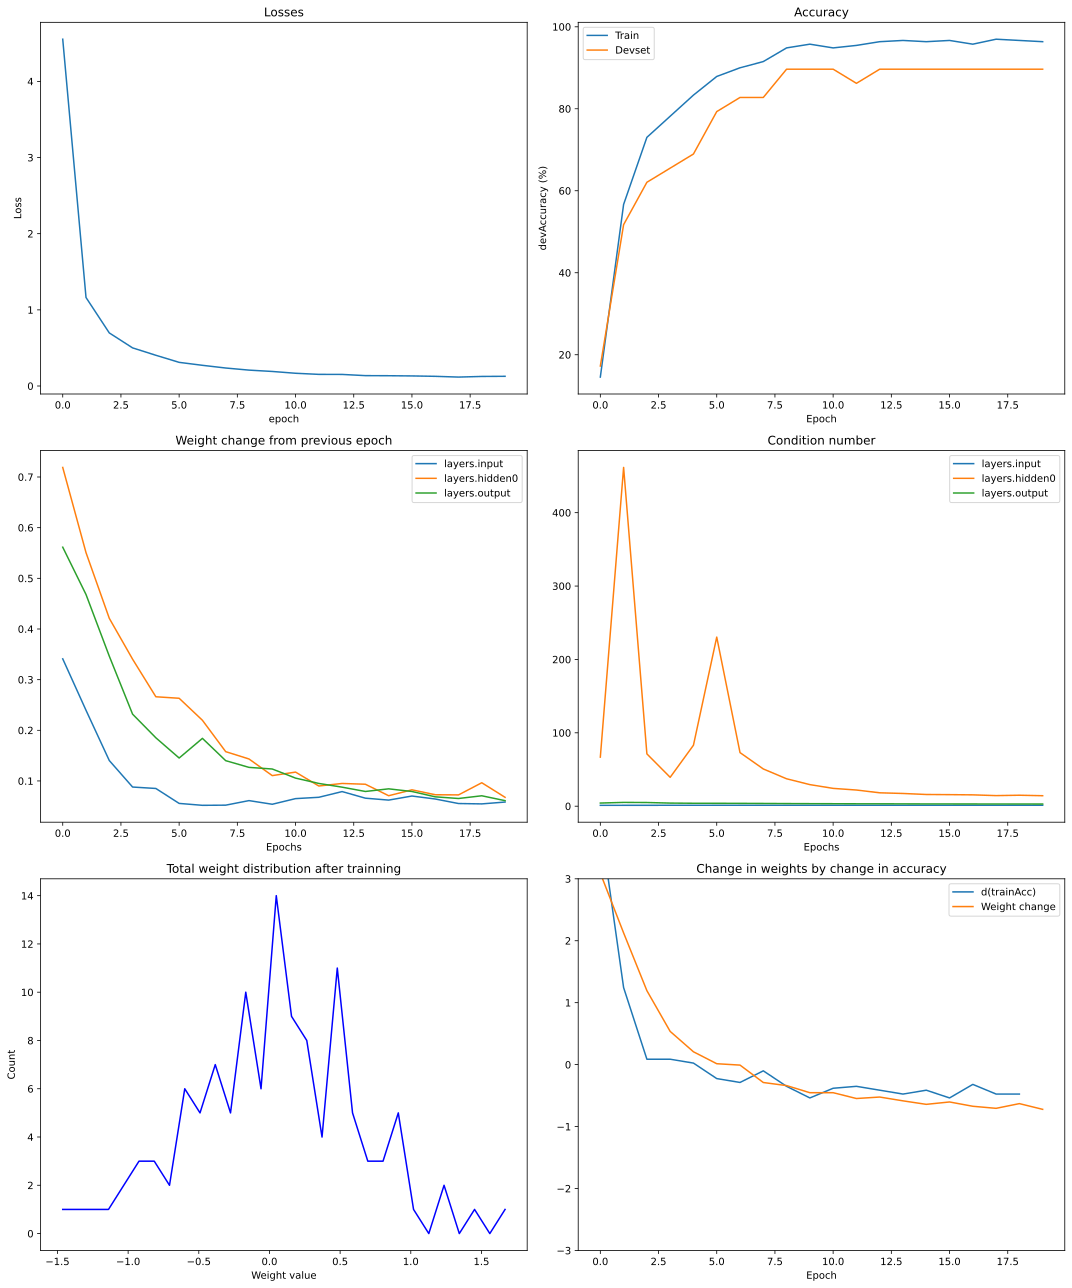

In [6]:
n.drawModel()

*** Now, let's do it in Tensorflow/Keras

In [7]:
import tensorflow as tf
print(tf.__version__)


2.9.1
